<a href="https://colab.research.google.com/github/IshwaryaSriram/NIDS/blob/main/AdversarialAttacks/Adversarial_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
!pip install cleverhans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 109 kB/s 
     |████████████████████████████████| 42 kB 1.0 MB/s 
     |████████████████████████████████| 154 kB 18.1 MB/s 


In [ ]:
!pip install np_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 549 kB/s 
  Created wheel for np-utils: filename=np_utils-0.6.0-py3-none-any.whl size=56459 sha256=ed97c3af391968fceebefbc91034158c62cf16c5eac4468854974bed69951e17
  Stored in directory: /root/.cache/pip/wheels/d2/83/71/a781667865955ae7dc18e5a4038401deb56d96eb85d3a5f1c0
Successfully built np-utils


In [ ]:
from sklearn import preprocessing
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras 
from keras.utils import np_utils
# from cleverhans.tf2.attacks import fast_gradient_method, \
#     basic_iterative_method, momentum_iterative_method
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.basic_iterative_method import basic_iterative_method
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.momentum_iterative_method import momentum_iterative_method

In [ ]:
from google.colab import  drive
# drive.mount('/drive')
df = pd.read_csv('/drive/My Drive/CIP/MulticlassDataset.csv')

In [ ]:
df.drop(['Unnamed: 0'],inplace=True,axis=1)
df.drop(['outcome'],inplace=True,axis=1)
df['label'].value_counts()

0    87832
1    54572
2     2131
3      999
4       52
Name: label, dtype: int64

In [ ]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [ ]:
from sklearn.preprocessing import StandardScaler
def feature_scaling(X):
  scaler = StandardScaler()
  scaler1 = scaler.fit_transform(X)
  return scaler1
X = feature_scaling(X)

In [ ]:
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.datasets import imdb
from keras.utils.np_utils import to_categorical
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
from sklearn.preprocessing import Normalizer
import h5py
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

In [ ]:
#dl 5 layers model
def create_tf_model(input_size, num_of_class):
    """ This method creates the tensorflow classification model """
    model_kddcup = tf.keras.Sequential([
        tf.keras.layers.Dense(1024, input_dim=input_size, activation='relu'),
        tf.keras.layers.Dropout(0.01),
        tf.keras.layers.Dense(768, activation='relu'),
        tf.keras.layers.Dropout(0.01),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.01),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.01),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_of_class),
        
        tf.keras.layers.Activation('softmax')
        ])
    model_kddcup.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])
    return model_kddcup



# # try using different optimizers and different optimizer configs
# model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# checkpointer = callbacks.ModelCheckpoint(filepath="kddresults/dnn5layer/checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='loss')
# csv_logger = CSVLogger('kddresults/dnn5layer/training_set_dnnanalysis.csv',separator=',', append=False)
# hist_5 = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),batch_size=batch_size, epochs=100, callbacks=[checkpointer,csv_logger])
# model.save("kddresults/dnn5layer/dnn5layer_model.hdf5")

In [ ]:
def fgsm_attack(org_model, x_test):
    """ This method creates adversarial examples with FGSM """
    logits_model = tf.keras.Model(org_model.input, model.layers[-1].output)

    epsilon = 0.1
    adv_fgsm_x = fast_gradient_method(logits_model, x_test,epsilon, np.inf )
    return adv_fgsm_x

def bim(org_model, x_test):
    """ This method creates adversarial examples with BIM """
    logits_model = tf.keras.Model(org_model.input, model.layers[-1].output)

    epsilon = 0.1
    adv_bim_x = basic_iterative_method(logits_model,
                                       x_test,
                                       epsilon,
                                       0.1,
                                       nb_iter=10,
                                       norm=np.inf,
                                       targeted=True)
    return adv_bim_x


def mim(org_model, x_test):
    """ This method creates adversarial examples with MIM """
    logits_model = tf.keras.Model(org_model.input, model.layers[-1].output)

    epsilon = 0.1
    adv_mim_x = momentum_iterative_method(logits_model,
                                          x_test,
                                          epsilon,
                                          0.1,
                                          nb_iter=100,
                                          norm=np.inf,
                                          targeted=True)
    return adv_mim_x

def pgd_attack(org_model, x_test):
    """ This method creates adversarial examples with PGD """
    logits_model = tf.keras.Model(org_model.input, model.layers[-1].output)

    epsilon = 0.1
    adv_fgsm_x = projected_gradient_descent(logits_model, x_test,epsilon, 0.1, norm =np.inf, nb_iter = 100 ,targeted = True )
    return adv_fgsm_x
  

In [ ]:
from sklearn.model_selection import train_test_split
EPOCH = 50
TEST_RATE = 0.2
VALIDATION_RATE = 0.2

num_class = len(np.unique(y))

attack_functions = [bim,
                    fgsm_attack,mim, pgd_attack]
X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                    test_size=TEST_RATE)
y_train_cat = np_utils.to_categorical(y_train)
y_test_cat = np_utils.to_categorical(y_test)


In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score

In [ ]:
conf_matrix1 = []
conf_matrix2 = []

In [ ]:
adv_train_x = []
adv_test_x = []


In [ ]:
adv_train_y = []
adv_test_y = []

In [ ]:
model = create_tf_model(X.shape[1], num_class)
history = model.fit(X_train, y_train_cat, epochs=EPOCH,
                            batch_size=50000, verbose=0,
                            validation_split=VALIDATION_RATE)

In [ ]:
for attack in attack_functions:
  adv_x = attack(model,X_train)
  for x in adv_x:
    adv_train_x.append(x.numpy())


  adv_x =  attack(model, X_test)
  for x in adv_x:
    adv_test_x.append(x.numpy())
  


In [ ]:
for i in range(4):
  adv_train_y.extend(y_train)
  adv_test_y.extend(y_test)

In [ ]:
y_train.value_counts()

0    70224
1    43684
2     1729
3      790
4       41
Name: label, dtype: int64

In [ ]:
len(adv_test_y)

116472

In [ ]:
import random
temp = list(zip(adv_train_x, adv_train_y))
random.shuffle(temp)
adv_train_x, adv_train_y = zip(*temp)

In [ ]:
temp = list(zip(adv_test_x, adv_test_y))
random.shuffle(temp)
adv_test_x, adv_test_y = zip(*temp)

In [ ]:
adv_test_x_sample = adv_test_x[:30000] 
adv_test_y_sample = adv_test_y[:30000]

In [ ]:
adv_test_x_sample[0]

array([-0.20785024, -0.11838274, -0.87862463,  0.84384246, -0.10424566,
        0.12998382, -0.11172155, -0.18439386, -0.10473694, -0.17020952,
       -0.11802181,  0.91716822, -0.1079052 , -0.11944033, -0.10861327,
       -0.12069373, -0.11827388, -0.15088331, -0.16875584, -0.79153514,
        0.09962702, -0.743361  , -0.45070778,  0.8717351 , -0.43702098,
        0.79654654, -1.82020044,  1.19023178, -0.51755518, -0.11171574,
        0.77791188])

In [ ]:
adv_test_x_sample = np.asarray(adv_test_x_sample)
adv_test_y_sample = np.asarray(adv_test_y_sample)

In [ ]:
adv_test_y_sample

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y_pred = np.argmax(model.predict(adv_test_x_sample), axis=-1)
print("Accuracy : ",accuracy_score(y_pred,adv_test_y_sample))
cm_adv = confusion_matrix(adv_test_y_sample, y_pred)
# conf_matrix2.append(cm_adv)
        # print("*"*20)
        # print("Attacked confusion matrix - adv training")
print(cm_adv)

Accuracy :  0.9942
[[17996    16    46    37     1]
 [   20 11240     2     0     0]
 [   18     3   406     0     0]
 [   27     0     0   178     0]
 [    3     0     0     1     6]]


In [ ]:
for attack_function in attack_functions:
        print("*"*20)
        print("Attack function is ", attack_function)
        
        model = create_tf_model(X.shape[1], num_class)
        history = model.fit(X_train, y_train_cat, epochs=EPOCH,
                            batch_size=50000, verbose=0,
                            validation_split=VALIDATION_RATE)
        
        X_adv_list = []
        y_adv_list = []

        adv_x =  attack_function(model, X_test)
        
        y_pred = np.argmax(model.predict(adv_x), axis=-1)
        print("Accuracy : ",accuracy_score(y_pred,y_test))
        #model.predict_classes(adv_x)
        cm_adv = confusion_matrix(y_test, y_pred)
        print("*"*20)
        print("Attacked confusion matrix")
        print(cm_adv)
        conf_matrix1.append(cm_adv)

        print("Adversarial training")
        # define the checkpoint

        adv_x = attack_function(model, X_train)
        adv_x_test = attack_function(model, X_test)

        concat_adv_x = np.concatenate([X_train, adv_x])
        concat_y_train = np.concatenate([y_train_cat, y_train_cat])

        history = model.fit(concat_adv_x, concat_y_train, epochs=EPOCH,
                            batch_size=50000, verbose=0,
                            validation_data=(adv_x_test, y_test_cat))

        y_pred = np.argmax(model.predict(adv_x_test), axis=-1)
        print("Accuracy : ",accuracy_score(y_pred,y_test))
        cm_adv = confusion_matrix(y_test, y_pred)
        conf_matrix2.append(cm_adv)
        print("*"*20)
        print("Attacked confusion matrix - adv training")
        print(cm_adv)

In [ ]:
import numpy as np
import keras
import os 
import glob
from keras.models import load_model
from keras import backend as K
from sklearn import metrics as m
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

sns.set_style('darkgrid')

Confusion Matrix 


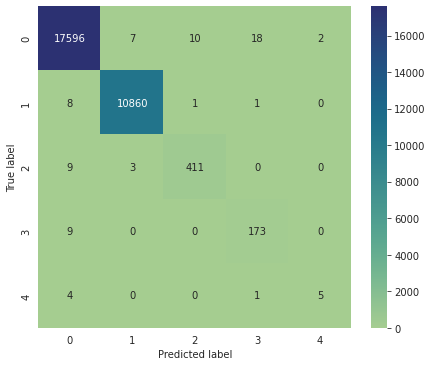

Confusion Matrix 


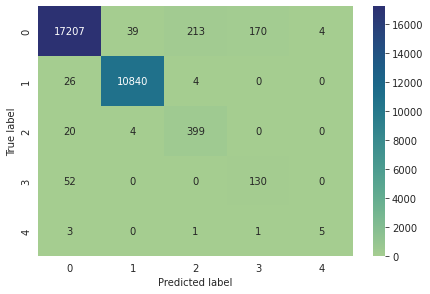

Confusion Matrix 


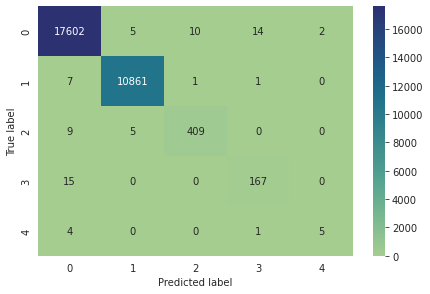

Confusion Matrix 


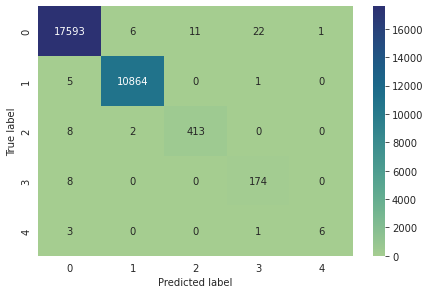

In [ ]:
figure = plt.figure(figsize=(6, 5))
for confusionmatrix in conf_matrix1: 
  print("Confusion Matrix ")
  sns.set_style('darkgrid')
  # current_palette = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
  sns.heatmap(confusionmatrix ,annot=True, fmt="d",cmap = 'crest')
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


Confusion Matrix 


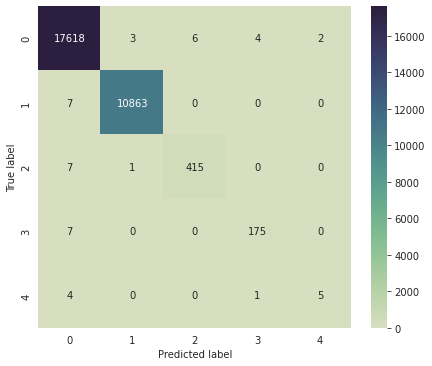

Confusion Matrix 


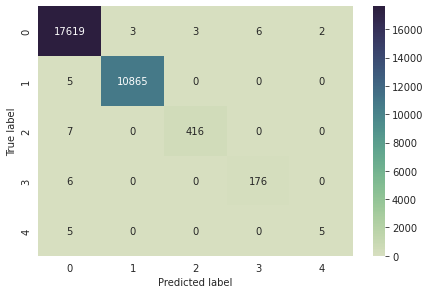

Confusion Matrix 


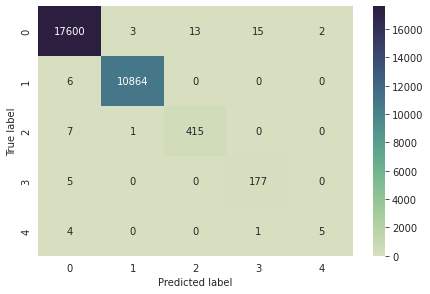

Confusion Matrix 


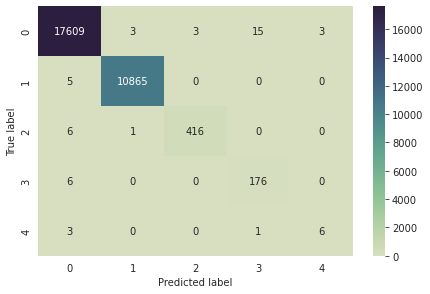

In [ ]:
figure = plt.figure(figsize=(6, 5))
for confusionmatrix in conf_matrix2: 
  print("Confusion Matrix ")
  # sns.set_style('darkgrid')
  # current_palette = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
  current_pallete = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
  sns.heatmap(confusionmatrix ,annot=True, fmt="d",cmap = current_pallete)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
